In [1]:
import datetime

from Decoder import *
from Finger import *
from LanguageModel import *
from TouchModel import *
from Keyboard import *
from metrics import *
from read_corpus import *
from visualiser import *
from Eye import *
import random
from Executor2 import *
from SpatialMemory import *

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import sympy as sp
from scipy.stats import entropy

import json


In [2]:
def decayfunc(x, a, b, c):
    return a * np.exp(-b * x) + c

def powerfunc(x, a, b):
    return a*(x**b)

def logistic_function (x, K, k, x0):
        #P(t) = K / (1 + e^(-k(t-t0)))
        #P(t) is performance at time t
        #K is the upper limit (maximum performance)
        #r is the learning rate
        #t0 is the midpoint time (inflection point)
        return K / (1 + math.e**(-k * (x - x0)))

In [3]:
# 8 participants, each participant types 8*12 phrases = 96

f=open('virtual_participants/popts_all.json')
participants = list(json.load(f).keys())
nparticipants = 8
participants = random.sample(participants, k=nparticipants)
#participants = sorted(list(json.load(f).keys()))[0:1]
layout = [2,1]

print (len(participants), participants)

trials = 12
sessions = 30
session_limit=20 #minutes

8 ['110', '111', '115', '105', '113', '121', '104', '109']


In [4]:
def runexp(keyboard, participants):

    #run experiment
    corpus = read_soukoreff('phrase_sets/mackenzie_and_soukoreff/mackenzie.txt')

    final_wpms = []
    final_wpm_sds = []
    final_kspcs = []
    final_blocks = []
    for p in participants:
        #select a phrase and remove it from corpus
        phraseidx = random.choice(range(0, len(corpus)))
        phrase = corpus.pop(phraseidx)
        print (phrase)
    
        #load participant
        eye = Eye()
        myfinger=Finger('virtual_participants/popts_all.json', p)
        mykeyboard = Keyboard('keyboards/'+keyboard+'.xml', 'languagemodel.json', 'touchmodel.json', [1400,1000],[0,0], usedecoder=False)
        sm = SpatialMemory(mykeyboard,region_columns=layout[0],region_rows=layout[1], learningRate=0.015, adjustment='dynamic')
        executor = Executor2(myfinger, eye, mykeyboard, sm, expert_factor=0.1)
        executor.memoryUpdateMethod = "logistic"
       
        print (p)
        
        all_wpms=[]
        all_wpms_sds=[]
        all_kspcs=[]
        all_blocks=[]
        for session in range(sessions):
            session_wpms=[]
            session_kspcs=[]
    
            timepassed = 0
            nblocks=0
    
            for i in range(trials):
            
                mykeyboard.outputbuffer=[]
                mykeyboard.current_word=[]
                mykeyboard.taps=[]
                eye.position = [mykeyboard.xdim/2, mykeyboard.ydim/2]
                executor.eye_positions=[]
                taps = executor.typeSentenceWithCorrection2(phrase, speed=1, noticeprob=1, slides='on', completions=False)
                session_wpms.append(taps['wpm'])
                session_kspcs.append(taps['kspc'])
                timepassed+=taps['time'] #minutes
                timepassed+=5/60 #add 5 seconds between phrases
                #print (session, nblocks, i, taps['wpm'], timepassed)
                nblocks+=1
            
            #print(p, session, nblocks, np.mean(session_wpms), np.mean(session_kspcs), sep='\t')
            all_wpms.append(np.mean(session_wpms))
            all_kspcs.append(np.mean(session_kspcs))
            all_wpms_sds.append(np.std(session_wpms))
            all_blocks.append(nblocks)
        
        final_wpms.append(all_wpms)
        final_wpm_sds.append(all_wpms_sds)
        final_kspcs.append(all_kspcs)
        final_blocks.append(all_blocks)
        print(p, np.mean(final_wpms), np.std(final_wpms), sep='\t')
    
    #run stats
    means = []
    for i in range(sessions):
        mean = []
        for p in range(len(participants)):
            mean.append(final_wpms[p][i])
        means.append(np.mean(mean))
        
    sdmeans = []
    for i in range(sessions):
        sdmean = []
        for p in range(len(participants)):
            sdmean.append(final_wpms[p][i])
        sdmeans.append(np.std(sdmean))
    
    blocks = []
    for i in range(sessions):
        b = []
        for p in range(len(participants)):
            b.append(final_blocks[p][i])
        blocks.append(np.mean(b))
        
    cis = []
    for i in range(sessions):
        sd = []
        for p in range(len(participants)):
            sd.append(final_wpms[p][i])
        cis.append(1.96*np.std(sd)/np.sqrt(len(participants)))
    
    delta_wpm = (means[7] - means[0])/means[0]
    print(round(delta_wpm,4)*100)
    print(means[0], sdmeans[0])
    print(means[7], sdmeans[7])
    print(means[len(means)-1], sdmeans[len(sdmeans)-1])

    return means, sdmeans, cis

def plotdata(means, sdmeans, cis):
    #plot
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    axes=[axes]
    
    #print actual session stats
    axes[0].scatter(range(len(means)), means, marker='.', alpha=0.5)
    #axes[1].plot(range(len(all_kspcs)), all_kspcs)
    axes[0].fill_between(
        range(len(means)), 
        [x - y for x, y in zip(means, cis)],
        [x + y for x, y in zip(means, cis)], 
        color='b', alpha=.15)
    
    
    #fit the function to first 8 sessions
    popt, pcov = curve_fit(powerfunc, range(0,8), means[0:8], maxfev=1000)
    y_pred = powerfunc(range(1,len(means)+1), *popt)
    r2=round(r2_score(means[0:8], y_pred[0:8]),3)
    print(r2)
    popt=np.append(popt,r2)
    r2=round(r2_score(means, y_pred),3)
    print(r2)
    popt=np.append(popt,r2)
    print(popt)
    label="$f(x)=%5.3fx^{%5.3f}, R^2=%5.3f, (%5.3f)$" %tuple(popt)
    axes[0].plot(range(1,len(means)+1), y_pred, label=label)
    
    #label=str(layout[0])+'x'+str(layout[1])+ ', $R^2$='+str(r2), #' - fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt), 
    
    
    #def logistic_function (x, K, k, x0):
    p0=(35,0.2,0)
    popt, pcov = curve_fit(logistic_function, range(1,9), means[0:8], maxfev=1000, p0=p0)
    y_pred = logistic_function(range(1,len(means)+1), *popt)
    r2=round(r2_score(means[0:8], y_pred[0:8]),3)
    print(r2)
    popt=np.append(popt,r2)
    r2=round(r2_score(means, y_pred),3)
    print(r2)
    popt=np.append(popt,r2)
    print(popt)
    if (popt[2]<0):
        sym="+"
    else:
        sym="-"
    popt[2]=abs(popt[2])
    label=("$f(x)=%5.3f/(1+e^{-%5.3f(x"+sym+"%5.3f)}), R^2=%5.3f, (%5.3f)$") %tuple(popt)
    axes[0].plot(range(1,len(means)+1), y_pred, label=label)
    
    #axes[0].plot(range(1,len(means)+1), y_pred,label="$f(x)=K/(1+e^{-k(x-x_0)}), R^2="+str(round(r2,3))+"$")
    
    #mackenzie's function
    popt=np.array([15.64,0.3273]) #opti
    #popt=np.array([35.684,-0.016]) #qwerty
    y_pred=powerfunc(range(1,len(means)+1),*popt)
    r2=round(r2_score(means[0:8], y_pred[0:8]),3)
    print(r2)
    popt=np.append(popt,r2)
    r2=round(r2_score(means, y_pred),3)
    print(r2)
    popt=np.append(popt,r2)
    print(popt)
    label="$f(x)=%5.3fx^{%5.3f}, R^2=%5.3f, (%5.3f)$" %tuple(popt)
    axes[0].plot(range(1,len(means)+1), y_pred, label=label)
    
    axes[0].legend()
    axes[0].set_ylim(0,65)
    axes[0].set_xlim(1,len(means)+1)
    axes[0].set_xlabel('Session')
    axes[0].set_ylabel('WPM')
    axes[0].vlines(x = 8,
                      ymin=0,
                      ymax=65,
                      color = 'black', linestyle='dashed', alpha=0.8)
    plt.show()

In [5]:
m,s,c=runexp('qwerty', participants)

the first time he tried to swim
Reconstructed object
110
110	0.1908855730453416	0.31507013023952507
the children are playing
Reconstructed object
111
111	0.22067321008064752	0.3716484283897601
circumstances are unacceptable
Reconstructed object
115
115	0.2026322530884246	0.34346528160053175
this is a very good idea
Reconstructed object
105
105	0.22528001204689788	0.40279263189220554
zero in on the facts
Reconstructed object
113
113	0.21058135879011688	0.383683730396869
motivational seminars make me sick
Reconstructed object
121
121	0.20562007287956668	0.37459144036194286
dolphins leap high out of the water
Reconstructed object
104
104	0.19984366652474075	0.35988962824973475
the insulation is not working
Reconstructed object
109
109	0.1973852610260332	0.3512794795873378
-90.93
1.9214912046321035 0.510526479718475
0.17435276072470154 0.0493963777373567
0.0544078406656358 0.011665931609478507


/var/folders/cq/dpv74_vx6z763s2ht4_54zx1tyht7_/T/ipykernel_61248/1223813342.py:5: RuntimeWarning: divide by zero encountered in power
  return a*(x**b)


-0.142
-0.063
[ 2.81718685e-01  4.57593437e-07 -1.42000000e-01 -6.30000000e-02]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

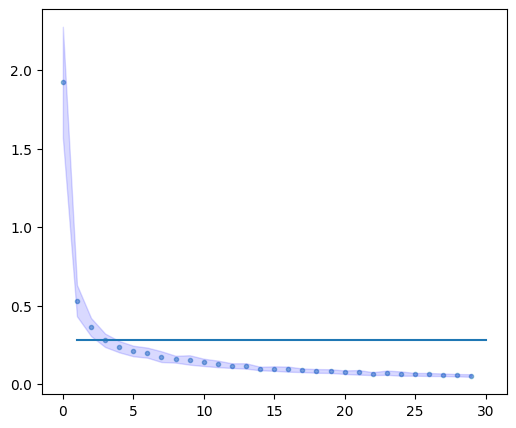

In [6]:
plotdata(m,s,c)

In [11]:
#original
plotdata(m,s,c)

/var/folders/cq/dpv74_vx6z763s2ht4_54zx1tyht7_/T/ipykernel_54085/1223813342.py:5: RuntimeWarning: divide by zero encountered in power
  return a*(x**b)


0.806
0.938
[16.40273644  0.14034393  0.806       0.938     ]
0.995
0.923
[25.52072215  0.18776567 -1.50296582  0.995       0.923     ]
-8.648
-17.886
[ 15.64     0.3273  -8.648  -17.886 ]


In [7]:
m1,s1,c1=runexp('opti', participants)

Reconstructed object
116
116	33.29167817445055	3.7580575578880544
Reconstructed object
127
127	28.288098437694824	5.9039954033633855
Reconstructed object
112
112	29.086084145753713	5.300167196346913
Reconstructed object
111
111	29.58017692773793	4.948925562747526
Reconstructed object
123
123	28.268574810807227	5.220679085343971
Reconstructed object
115
115	27.894461413608774	4.9195415354773315
Reconstructed object
129
129	27.530134511063167	4.727208560352844
Reconstructed object
108
108	27.69097940460134	4.577429999050399
17.97
21.915406108794926 2.785372880849393
25.85346410708853 3.347529179353308
30.227356694180298 4.350443997099398


In [8]:
plotdata(m1,s1,c1)

/var/folders/cq/dpv74_vx6z763s2ht4_54zx1tyht7_/T/ipykernel_54085/1223813342.py:5: RuntimeWarning: divide by zero encountered in power
  return a*(x**b)


0.705
0.208
[22.93332662  0.05032158  0.705       0.208     ]
0.929
0.756
[28.82897381  0.12280055 -8.94617792  0.929       0.756     ]
-10.121
-16.316
[ 15.64     0.3273 -10.121  -16.316 ]
